In [1]:
# Uncomment to install needed libraries
# !pip install -U nltk 
# !pip install pattern
#!pip install spacy
# python -m spacy download en_core_web_md %run this in cmd%
#!pip install autoviz
# !pip install pattern

In [2]:
import numpy as np 
import pandas as pd

#data visualization
import pandas_profiling 
import matplotlib.pyplot as plt
%matplotlib inline 
import pydot  # for keras model graph visualization
import graphviz
import seaborn as sns
from autoviz.AutoViz_Class import AutoViz_Class
from keras.utils import plot_model


# Text preprocessing
import string
import spacy ## built-in word-embeddings vectors
import nltk
from nltk.stem.porter import PorterStemmer 
from nltk.corpus import stopwords
from pattern.en import singularize   ## as nltk english set just has the singular form of the word so need to sigularize plurals 

#Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn import metrics


from category_encoders import TargetEncoder

#Keras 
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input,Embedding,LSTM,Dense,Dropout,SpatialDropout1D,concatenate,Bidirectional,GlobalMaxPooling1D,GlobalAveragePooling1D,add,BatchNormalization

from keras import activations
import keras.backend as K
from keras.callbacks import EarlyStopping,ModelCheckpoint


Imported AutoViz_Class version: 0.0.68. Call using: 
    from autoviz.AutoViz_Class import AutoViz_Class
    AV = AutoViz_Class()
    AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=0,
                            lowess=False,chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30)
            
To remove previous versions, perform 'pip uninstall autoviz'


## **Data Visualization** 


In [3]:
train_data=pd.read_csv("train.csv")
test_data=pd.read_csv("test.csv")
print("Number of Training Examples",train_data.shape[0])
print("Number of Test Examples",test_data.shape[0])
train_data.head(5)

Number of Training Examples 7613
Number of Test Examples 3263


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
report = pandas_profiling.ProfileReport(train_data)
display(report)

* note: from Visualization above , Location has 2533(33.3%) NAN values and Keyword has 61 NAN values(0.8 %)

* Intresting note: in some data points, the **kewyord col** does not exist in the tweet!!

## Data Preprocessing


In [5]:
#  helper function to fill nan values in keyword column
# By checking if the for each data point if its text has any word existed previously in keywords 


unique_list=train_data["keyword"].unique()
str1=''
for i in unique_list[1:]:  # exclude nan value and convert list to str
    str1=str1+' '+i
unique_list2=str1.replace('%20',' ').split()   # to get rid of a variable in keywords like bridge%20collapse
    
def Fill_NAN_Keyword(x):
    x_copy=x.copy()
    nan_rows=x_copy["keyword"].isna()==True
    for i in x_copy.loc[nan_rows].index:
        for item in x_copy.loc[nan_rows].text[i].replace('#','').lower().split():
            if item in unique_list2:
                x_copy.keyword[i]=item
                
# After this great work above,Halola, I am only left few NAN-Keyword data points          
# Assume that the rest of NAN values has NONE value 
    x_copy.keyword.fillna('None',inplace=True)        
    return x_copy

In [6]:
#helper function to get the stem word for each word in keyword col.

print("in the unique list of keywords there are words that have the same in meaning but in different forms like\n",
      unique_list[47:52], "\n That's why we need stem words" )

porter = PorterStemmer()
def Stem_Words(x):
    x["keyword_stem"]=''
    for i in range(len(x)):
        x["keyword_stem"][i]=porter.stem(x["keyword"][i].replace('%20',' '))
    return x


in the unique list of keywords there are words that have the same in meaning but in different forms like
 ['collapse' 'collapsed' 'collide' 'collided' 'collision'] 
 That's why we need stem words


In [7]:
### Encoding Categorical Features, keyword,location
def Target_Encoding(df_train,df_test,col):
    te=TargetEncoder()
    te.fit(df_train[col],df_train.target)
    df_train[col+'_enc']=te.transform(df_train[col],df_train.target)        
    df_test[col+'_enc']=te.transform(df_test[col])


In [8]:
# Function_Calls

## Fill_NAN_Values in keyword col
train_data_copy=Fill_NAN_Keyword(train_data)
test_data_copy=Fill_NAN_Keyword(test_data)

train_data_copy=Stem_Words(train_data_copy)
test_data_copy=Stem_Words(test_data_copy)

## Fill_NAN_Values in location col using simple imputation(most frequent)
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train_data_copy["location"]=imp.fit_transform(np.array(train_data_copy.location).reshape(-1, 1))
test_data_copy["location"]=imp.fit_transform(np.array(test_data_copy.location).reshape(-1, 1))

        
# Target Encoding 
Target_Encoding(train_data_copy,test_data_copy,col='location')
Target_Encoding(train_data_copy,test_data_copy,col='keyword_stem')

In [9]:
## Validation & Training Split

X_train_=train_data_copy.drop(columns=["location",'id','keyword_stem','keyword','target'])
y_train_=train_data_copy.target
X_test=test_data_copy.drop(columns=["location","id",'keyword_stem','keyword'])
X_train, X_val, y_train, y_val = train_test_split( X_train_, y_train_, test_size=0.1, random_state=0,shuffle=False)
print("Number of Training Examples ",X_train.shape[0])
print("Number of Validation Examples ",X_val.shape[0])

Number of Training Examples  6851
Number of Validation Examples  762


It seems that there is high corrolation between keyword and target as well as location and target which is good


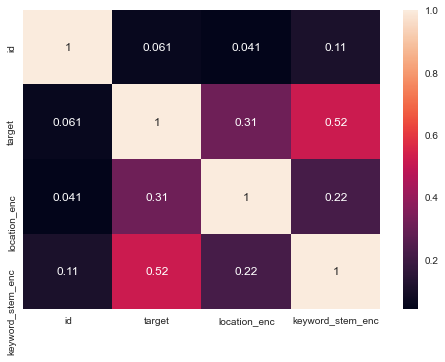

In [10]:
## Corrolation Matrix 

corr=train_data_copy.corr()
sns.heatmap(corr, annot=True)
print("It seems that there is high corrolation between keyword and target as well as location and target which is good")

### model using just keyword and location info

In [11]:
# a simple model using location and Keywords

clf = RandomForestClassifier( random_state=4)
clf.fit(X_train.drop(columns=['text']), y_train)
print("Training Acc",clf.score(X_train.drop(columns=['text']), y_train))
print("Validation Acc",clf.score(X_val.drop(columns=['text']),y_val))
pred_clf=clf.predict(X_test.drop(columns=['text']))

print("\n\nscored 0.69200 acc on test data , Actually not very bad ")

Training Acc 0.7930229163625748
Validation Acc 0.7690288713910761


scored 0.69200 acc on test data , Actually not very bad 


## Let's deal now with THE TEXT (terrifing)

In [12]:
#importing English Corpus
#nltk.download('words')
words_english_set = set(nltk.corpus.words.words())

In [13]:
# stop word are the word that do not contribute to the meaning Let's remove them to ease computation
# nltk.download('stopwords')  //uncomment this to download the module
stop_words = set(stopwords.words('english'))
print(stop_words)

{'doesn', 'couldn', 'against', 'herself', "shan't", 'which', "you've", 'of', 'shouldn', 'hers', 'itself', 'was', 'most', 've', 'only', 'isn', 'nor', 'its', 'himself', 'mustn', 'same', 'doing', "you'll", 'but', 'such', 'by', 'into', 'hadn', 'from', 'needn', 'were', 'wasn', 'more', 'then', 'before', 'having', 'it', 'they', 'where', 'don', 'theirs', 'weren', 'why', 'as', 'or', "needn't", 'this', 'themselves', 'until', 'their', 'up', 'so', 'myself', 'his', 'do', 'when', 'that', 'over', 'my', 'been', 'some', 'haven', 'few', 'any', 'them', 'are', "it's", 'can', 'is', 'not', "shouldn't", 'ours', 'because', 'y', "weren't", 'him', 'further', 'each', 'has', 'below', "couldn't", 'hasn', 'shan', 'through', 'your', 'if', 'll', 'between', "you're", 'at', 'she', "aren't", 'have', "haven't", 'other', 'be', 'does', 'both', 'yourselves', "wasn't", "you'd", 'own', 'just', "hasn't", 're', 'under', 'after', 'you', 'very', 'an', "hadn't", "mustn't", 'these', 'down', "didn't", 'while', 'will', 'ma', 'aren', 

In [14]:
# cleaning Function does:

# * ALL text in lower case
# * split by white space
# * remove Punctuation 
# * remove Stop Words

table = str.maketrans('', '', string.punctuation)
def cleaning(x):
    words=x.lower().split()
    stripped = [w.translate(table) for w in words]
    words = [w for w in stripped if not w in stop_words]
    words=[w for w in words if singularize(w) in words_english_set]
    return words

In [15]:
# Apply the above function to the text col.

X_train['tokens']=X_train.text.apply(cleaning)
X_test['tokens']=X_test.text.apply(cleaning)
X_val['tokens']=X_val.text.apply(cleaning)

## WORKING WITH SPACY 
( Pretrained word Embeddings)

In [16]:
## Loading 

nlp = spacy.load('en_core_web_md')
all_words=list(nlp.vocab.strings)

# process a sentence using the model
#doc = nlp("This is some man that I am woman with orange")
#doc.vector # average vector for the sentence
# doc[2].vector # third word vector

**my first time trying Spacy so just playing around**


In [17]:
## copied from my lab assignment on NLP course , coursera, but modified to work with spacy not golVe 
def cosine_similarity(u, v):
    """
    Cosine similarity reflects the degree of similarity between u and v
        
    Arguments:
        u -- a word vector of shape (n,)          
        v -- a word vector of shape (n,)

    Returns:
        cosine_similarity -- the cosine similarity between u and v defined by the formula above.
    """
    
    distance = 0.0
    
    ### START CODE HERE ###
    # Compute the dot product between u and v (≈1 line)
    dot = np.dot(u,v)
    # Compute the L2 norm of u (≈1 line)
    norm_u = np.linalg.norm(u)
    
    # Compute the L2 norm of v (≈1 line)
    norm_v = np.linalg.norm(v)
    # Compute the cosine similarity defined by formula (1) (≈1 line)
    cosine_similarity = dot/(norm_u*norm_v)
    ### END CODE HERE ###
    
    return cosine_similarity

In [18]:
father = nlp("Father")
mother=nlp("mother")
ball=nlp("ball")
doctor=nlp("computer")
print(cosine_similarity(father.vector, mother.vector))
# I tried more than that but I decided to keep it to myself 

0.8298246


In [19]:
## copied from my lab assignment on NLP course , coursera, but modified to work with spacy not GolVe 
def complete_analogy(word_a, word_b, word_c):
    """
    Performs the word analogy task as explained above: a is to b as c is to ____. 
    
    Arguments:
    word_a -- a word, string
    word_b -- a word, string
    word_c -- a word, string
    word_to_vec_map -- dictionary that maps words to their corresponding vectors. 
    
    Returns:
    best_word --  the word such that v_b - v_a is close to v_best_word - v_c, as measured by cosine similarity
    """
    
    # convert words to lowercase
    word_a, word_b, word_c = word_a.lower(), word_b.lower(), word_c.lower()
    
    ### START CODE HERE ###
    # Get the word embeddings e_a, e_b and e_c (≈1-3 lines)
    e_a, e_b, e_c = nlp(word_a).vector,nlp(word_b).vector,nlp(word_c).vector
    ### END CODE HERE ###
    
    words = all_words[1:10000]
    max_cosine_sim = -100              # Initialize max_cosine_sim to a large negative number
    best_word = None                   # Initialize best_word with None, it will help keep track of the word to output

    # to avoid best_word being one of the input words, skip the input words
    # place the input words in a set for faster searching than a list
    # We will re-use this set of input words inside the for-loop
    input_words_set = set([word_a, word_b, word_c])
    
    # loop over the whole word vector set
    for w in words:        
        # to avoid best_word being one of the input words, skip the input words
        if w.lower() in input_words_set:
            continue
        
        ### START CODE HERE ###
        # Compute cosine similarity between the vector (e_b - e_a) and the vector ((w's vector representation) - e_c)  (≈1 line)
        cosine_sim = cosine_similarity((e_b-e_a),(nlp(w).vector-e_c))
        
        # If the cosine_sim is more than the max_cosine_sim seen so far,
            # then: set the new max_cosine_sim to the current cosine_sim and the best_word to the current word (≈3 lines)
        if cosine_sim > max_cosine_sim:
            max_cosine_sim = cosine_sim
            best_word = w
        ### END CODE HERE ###
        
    return best_word

In [20]:
# uncomment to find the analogy 
#word_a="man"
#word_b="women"
#word_c="king"

#an=complete_analogy(word_a, word_b, word_c)
#print(an)
# result is "females" and that is unexpected

### Let's get back to the model 
#### Our data is ready now for some actions
* First Let's create the weight matrix for the embedding layer



In [21]:
## copied from my lab assignment on NLP course , coursera, but modified to work with spacy not GolVe 

def pretrained_embedding_layer():
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.
    
    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    
    vocab_len = len(all_words) + 1                  # adding 1 to fit Keras embedding (requirement)
    emb_dim = nlp("cucumber").vector.shape[0]      # define dimensionality of your GloVe word vectors (= 50)
    
    ### START CODE HERE ###
    # Step 1
    # Initialize the embedding matrix as a numpy array of zeros.
    # See instructions above to choose the correct shape.
    emb_matrix = np.zeros(((vocab_len,emb_dim)))
    
    # Step 2
    # Set each row "idx" of the embedding matrix to be 
    # the word vector representation of the idx'th word of the vocabulary
    k=0
    for word in all_words:
        emb_matrix[k, :] = nlp(word).vector
        k=k+1
        
    
    return emb_matrix

In [22]:
## copied from my lab assignment on NLP course , coursera (they were using GloVe not Spacy)
## input list of tokens 
## Output indices matrix with shape(m,max_len)
def sentences_to_indices(X):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()` (described in Figure 4). 
    
    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this. 
    
    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """
    
    m = X.shape[0]                                   # number of training examples
    max_len=25
    ### START CODE HERE ###
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m,max_len))
    L=[]                                             # A list of skipped words
    for i in range(m):                               # loop over training examples
        
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words =X[i]
        #.lower().split()
        
        # Initialize j to 0
        j = 0
        
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in all_words[:499999]:
                X_indices[i, j] = all_words.index(w)
                # Increment j to j + 1
                j = j+1
            else:
                L.append(w)
                
            
    ### END CODE HERE ###
    
    return X_indices,L

In [23]:
# Load Emb_weights

#emb_weights is 6GB!!!!(1,476,295,300) and took a lot of time so I saved it and just will load a part of it 

## uncomment for first time running
#emb_weights=pretrained_embedding_layer()
#pd.DataFrame(emb_weights).to_csv("emb_weights.csv",index=False)
emb_weights_500000=pd.read_csv("emb_weights.csv",nrows=500000)

In [24]:
#get the indecies_matrix for training data 

# L list helped me chose the number of 500000 as my vocab len 

#X,L=sentences_to_indices(X_train.tokens)
#pd.DataFrame(X).to_csv("X_Train_indices.csv",index=False)
X=pd.read_csv("X_Train_indices.csv")
X_val.reset_index(inplace=True)
x_val,dummy1=sentences_to_indices(X_val.tokens)
x_test,dummy2=sentences_to_indices(X_test.tokens)

In [25]:
# Variables Shared among all models

vocab_len=len(all_words[:499999])+1  #number of words in the vocab +1 for any unknown word
emb_dim=len(nlp("mother").vector)  # embedded vector dimension (300)
maxLen=25    # max words per sentence
LSTM_UNITS=128

#### Model I
**0.78 acc on test data**

In [26]:
input_shape=(maxLen,)
model = keras.Sequential()
model.add(Input(shape=input_shape,dtype='int32'))
model.add(Embedding(input_dim=vocab_len,output_dim=emb_dim,weights=[emb_weights_500000],trainable=False))
    # The returned output should be a batch of sequences. 
model.add(LSTM(units = LSTM_UNITS, return_sequences= True,))
model.add(Dropout(0.2))
    # The returned output should be a single hidden state, not a batch of sequences.
model.add(LSTM(units = LSTM_UNITS)) 
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(10,activation='relu'))
model.add(Dense(1,activation='sigmoid'))


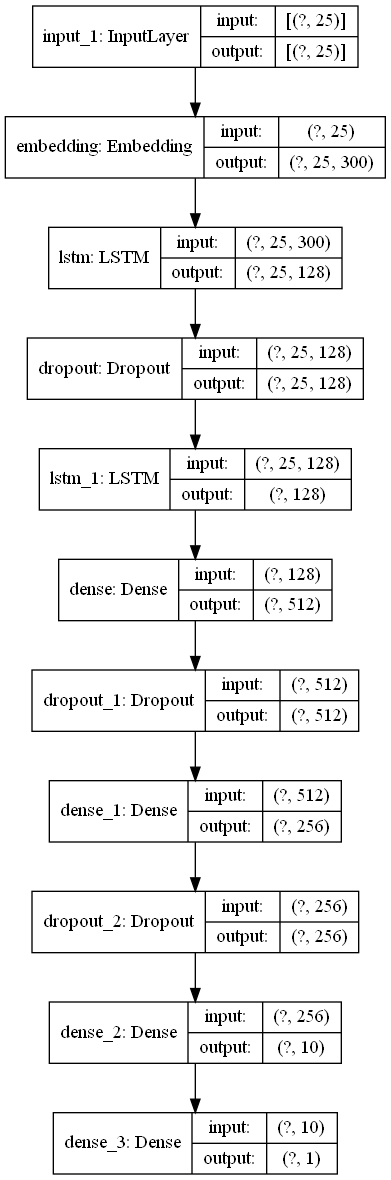

In [27]:
#Model Visualization 

#model.summary()
plot_model(model, "model1.png", show_shapes=True)

#### model II


**Using TWO INPUTS( keyword and text)**


In [28]:
#0.793 text acc, dense 128
# 0.83 2 -- 256 
# 3 256 0.3 128 000
# 4 256 --16 000
#5 256 12
# ____ 
# bn nice 0.82 
# coment dropout 

DENSE_HIDDEN_UNITS=LSTM_UNITS*4

#input_layer
input_shape_tokens=(maxLen,)
input_shape_keyword=(1,)
words = Input(shape=input_shape_tokens,dtype='int32')
keyword_input=Input(shape=input_shape_keyword)

# Keyword Branch
k=Dense(128,activation='relu')(keyword_input)
#k=Dropout(0.3)(k)
#k=Dense(128,activation='relu')(k)

# Text Branch
x =Embedding(input_dim=vocab_len,output_dim=emb_dim,weights=[emb_weights_500000],trainable=False)(words)
x = SpatialDropout1D(0.2)(x)
x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True,kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4)))(x)
x=BatchNormalization()(x)
x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
x=BatchNormalization()(x)
hidden = concatenate([
        GlobalMaxPooling1D()(x),
        GlobalAveragePooling1D()(x)])
hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
hidden=Dropout(0.2)(hidden)
x=BatchNormalization()(x)
hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
hidden=Dropout(0.2)(hidden) 

#k=layers.Dropout(0.1)(k)
#k=layers.Dense(16,activation='relu')(k)
#k=layers.Dense(16,activation='relu')(k)
# Concatination
hidden=concatenate([hidden,k])
#hidden=layers.Dropout(0.2)(hidden)
#hidden=Dense(16,activation='relu')(hidden)

# Output
result = Dense(1, activation='sigmoid')(hidden)
    
model2 = keras.Model(inputs=[words,keyword_input], outputs=result)


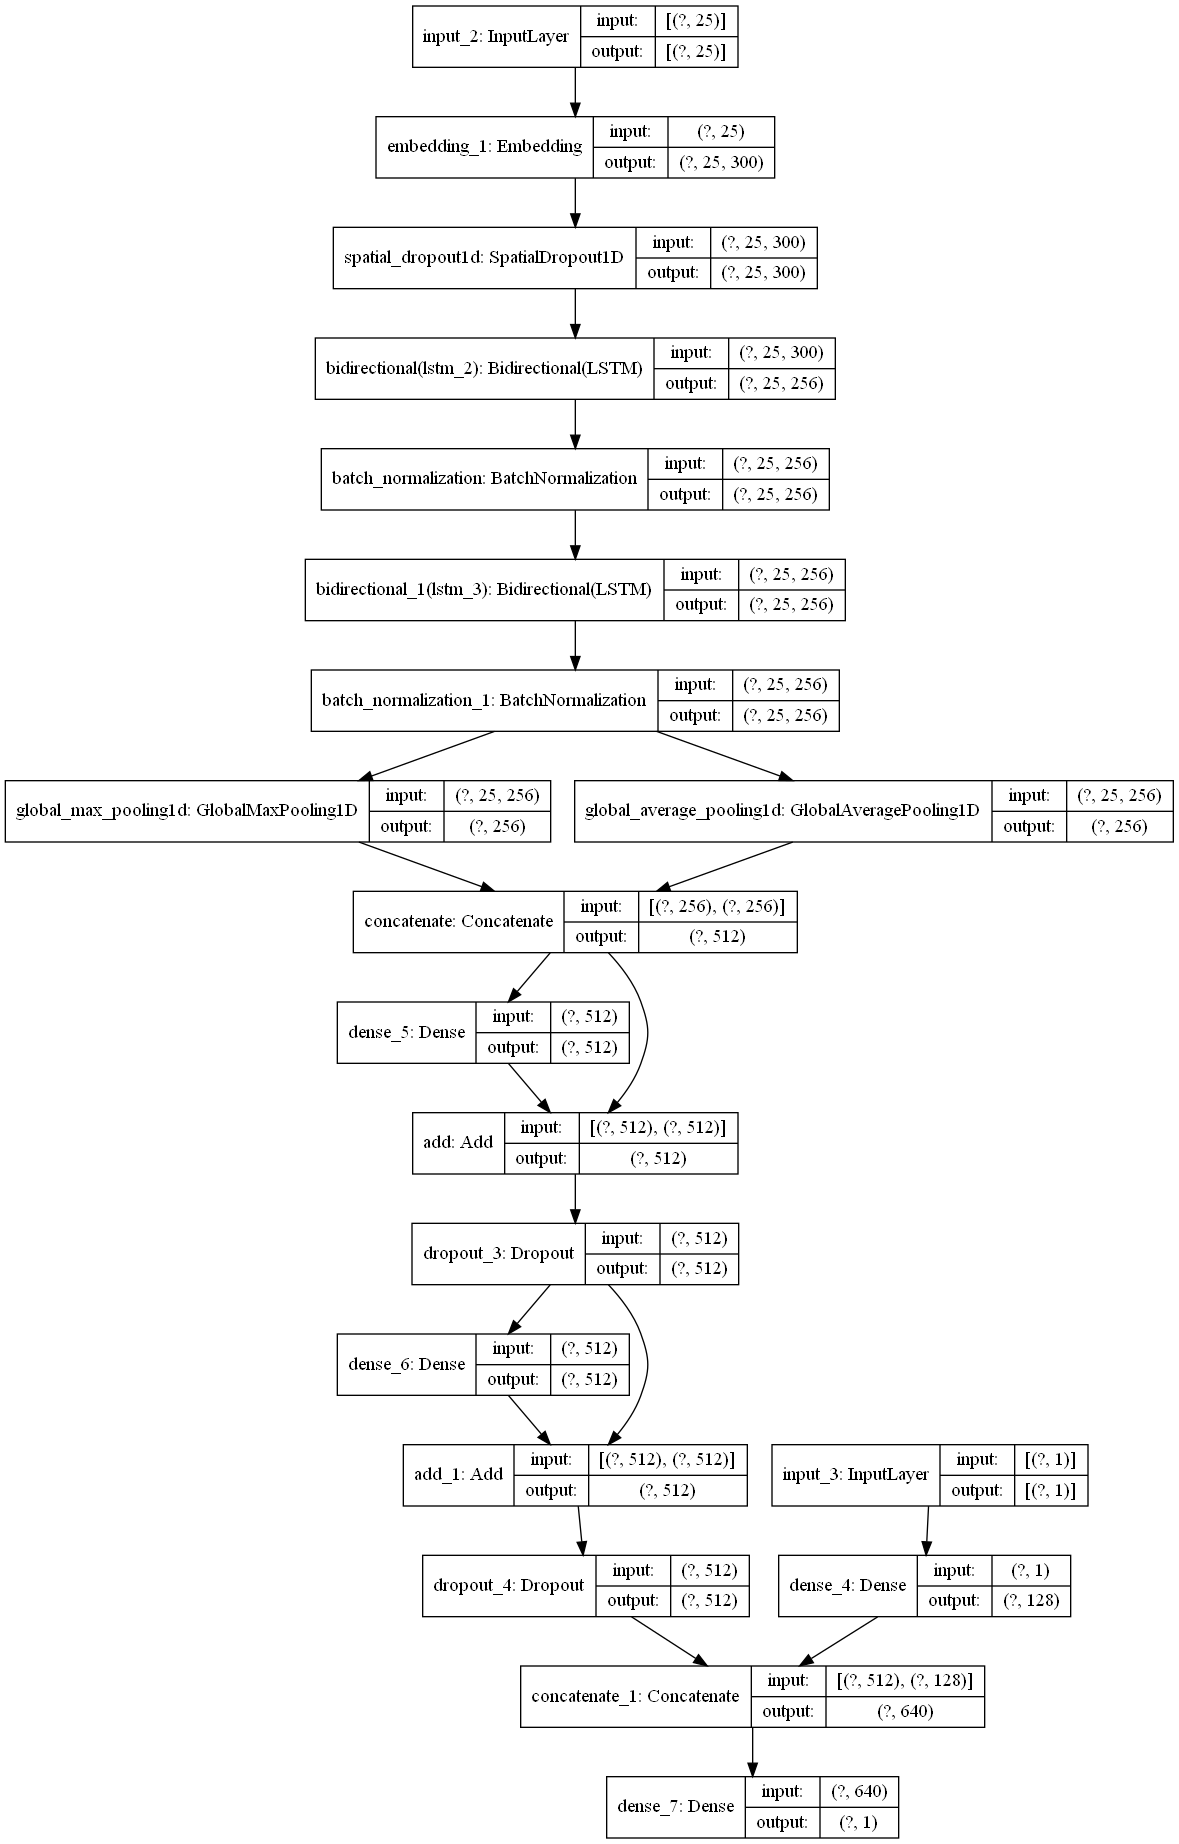

In [29]:
# Model Visualization

plot_model(
    model2,
    to_file="model2.png",
    show_shapes=True,
)

In [30]:
# Model Check Point

filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
callback = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

##### Compiling

In [31]:
opt=keras.optimizers.Adam()
model2.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy']) 
model2.save_weights('model.h5')   #save Initial model weights


##### Training 

In [32]:

model2.load_weights('model.h5')  # load Initial model weights
history=model2.fit([X,X_train.keyword_stem_enc], y_train, epochs=12,validation_data =([x_val,X_val.keyword_stem_enc],y_val),batch_size = 32, shuffle=True,callbacks=[callback])  

Epoch 1/12
215/215 [==============================] - ETA: 0s - loss: 0.8766 - accuracy: 0.7078
Epoch 00001: val_accuracy improved from -inf to 0.79396, saving model to weights-improvement-01-0.79.hdf5
215/215 [==============================] - 37s 173ms/step - loss: 0.8766 - accuracy: 0.7078 - val_loss: 0.6845 - val_accuracy: 0.7940
Epoch 2/12
215/215 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.7685
Epoch 00002: val_accuracy improved from 0.79396 to 0.80184, saving model to weights-improvement-02-0.80.hdf5
215/215 [==============================] - 34s 158ms/step - loss: 0.6844 - accuracy: 0.7685 - val_loss: 0.6201 - val_accuracy: 0.8018
Epoch 3/12
215/215 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.7821
Epoch 00003: val_accuracy improved from 0.80184 to 0.81496, saving model to weights-improvement-03-0.81.hdf5
215/215 [==============================] - 34s 158ms/step - loss: 0.6299 - accuracy: 0.7821 - val_loss: 0.5680 - val_acc

#### Model Evaluation 

Text(0.5, 1.0, 'accuracy vs iterations')

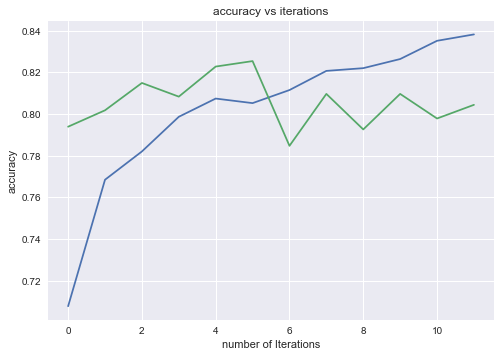

In [33]:
# accuracy vs iterations Plot
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("number of Iterations")
plt.ylabel("accuracy")
plt.title("accuracy vs iterations")

FalseNegative is bigger than FalsePositive which means that the model predicts it is a disaster when it is not , 
I do belive that cost of FP for this model is greater so our model is good I think


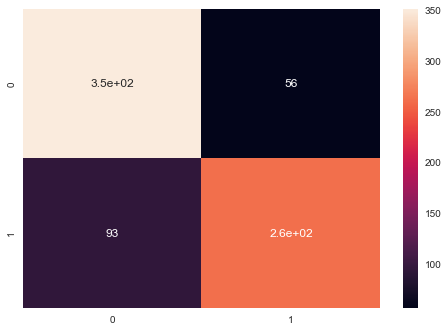

In [34]:
# Confusion Matrix
pred_val2=np.round(model2.predict([x_val,X_val.keyword_stem_enc,X_val.location_enc])).flatten()
matr=metrics.confusion_matrix(y_val, pred_val2)
tn, fp, fn, tp=matr.ravel()
sns.heatmap(matr, annot=True)
print("FalseNegative is bigger than FalsePositive which means that the model predicts it is a disaster when it is not , \nI do belive that cost of FP for this model is greater so our model is good I think")

In [35]:
## Load best weights to model 

model2.load_weights("weights-improvement-06-0.82.hdf5")

#### Model Prediction 

In [36]:
pred=np.round(model2.predict([x_test,X_test.keyword_stem_enc])).flatten()
df_sub=pd.DataFrame({"id":test_data.id,"target":pred},dtype=np.int64)
df_sub.to_csv("sub.csv",index=False)
pd.read_csv("sub.csv")

,id,target
0,0,1
1,2,1
2,3,0
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


### References
[1]  https://www.kaggle.com/bibek777/lstm-baseline/notebook
